In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
import oma_tracking.models.mlflow_functions as mlflow_f

from dotenv import load_dotenv
load_dotenv()

True

In [8]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'

# Data Paths
data_path = "../../data/nw2/raw/nw2d01_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = "../../data/nw2/mvbc_data.parquet"
tracked_frequencies_path = "../../data/nw2/tracked_modes/" + location + ".parquet"
simulations_data_path = "../../data/nw2/simulations/" + location + "/"

# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

In [9]:
AZURE_STORAGE_ACCESS_KEY = os.getenv('AZURE_STORAGE_ACCESS_KEY')
AZURE_STORAGE_CONNECTION_STRING = os.getenv('AZURE_STORAGE_CONNECTION_STRING')
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

artifact_root = 'wasbs://test@mlflowstoragev1.blob.core.windows.net'
mlflow_ui_string = mlflow_f.create_mlflow_ui(MLFLOW_TRACKING_URI, artifact_root)
database_url = 'http://127.0.0.1:5000'
mlflow_f.connect_mlflow_ui(mlflow_ui_string, database_url)

experiment_name = 'NW2_scour'
experiment = mlflow_f.run_mlflow_experiment(experiment_name = experiment_name)

c:\users\max\documents\owi_lab\code\packages\oma_tracking\oma_tracking\models\mlflow_functions.py:124: UserWarning: Mlflow_tracking_uri passed without checking checking username for ':' and '@' symbols. Manually control the uri!
  warnings.warn(


mlflow experiment set to: NW2_scour


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [11]:
weather_params = \
    [
        'Wave_height', 
        'Sea_water_temperature', 
        'Tide_TAW', 
        'Air_pressure', 
        'Air_temperature', 
        #'Relative_humidity' # TOO MANY NANs
    ]
weather_inputs = mvbc_data[weather_params]

scada_params = \
    [
        'mean_NW2_D01_rpm', 
        'mean_NW2_D01_yaw', 
        'mean_NW2_D01_pitch', 
        'mean_NW2_D01_power', 
        #'std_NW2_D01_towerxacc',  # TOO MANY NANs
        #'std_NW2_D01_toweryacc', # TOO MANY NANs
        #'mean_NW2_D01_towerxacc', # TOO MANY NANs
        #'mean_NW2_D01_toweryacc', # TOO MANY NANs
        'mean_NW2_D01_windspeed',
        'mean_NW2_D01_winddirection',
    ]
scada_inputs = data[scada_params]

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

2023/03/06 18:16:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/03/06 18:16:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/03/06 18:16:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/03/06 18:16:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/03/06 18:17:09 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/03/06 18:17:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2

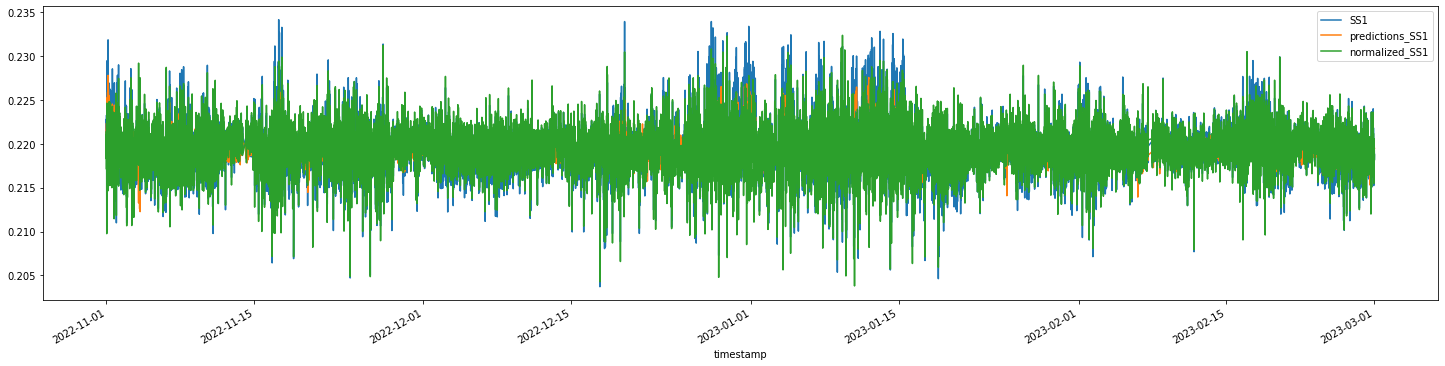

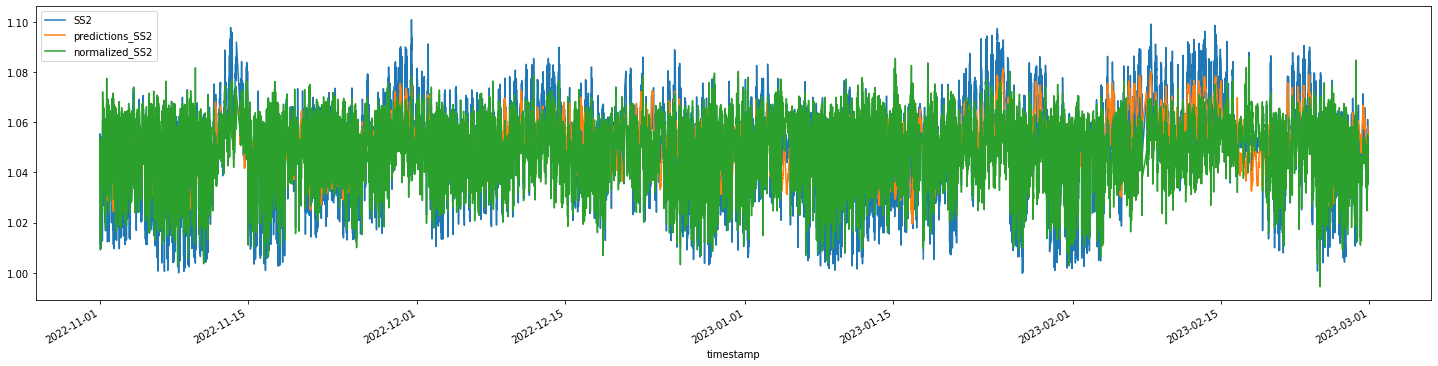

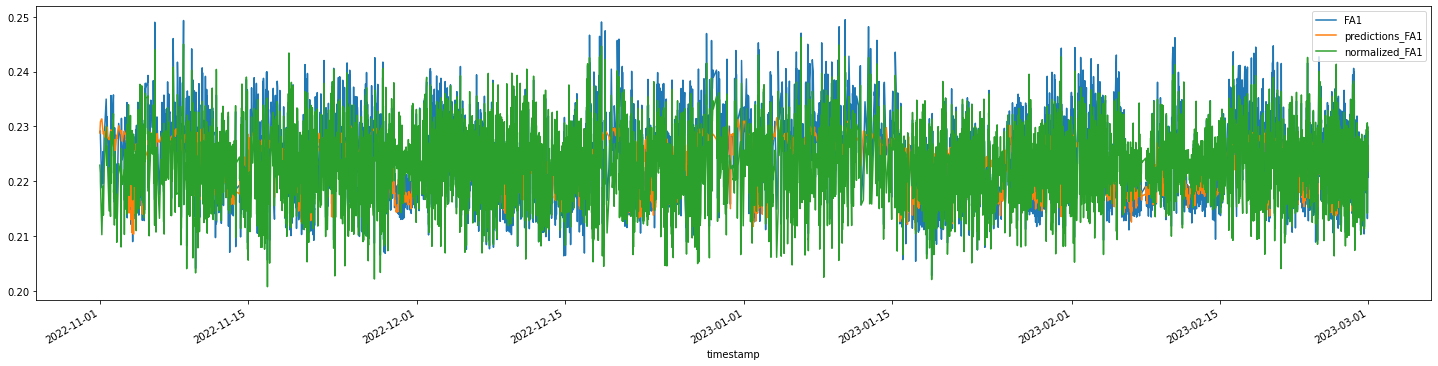

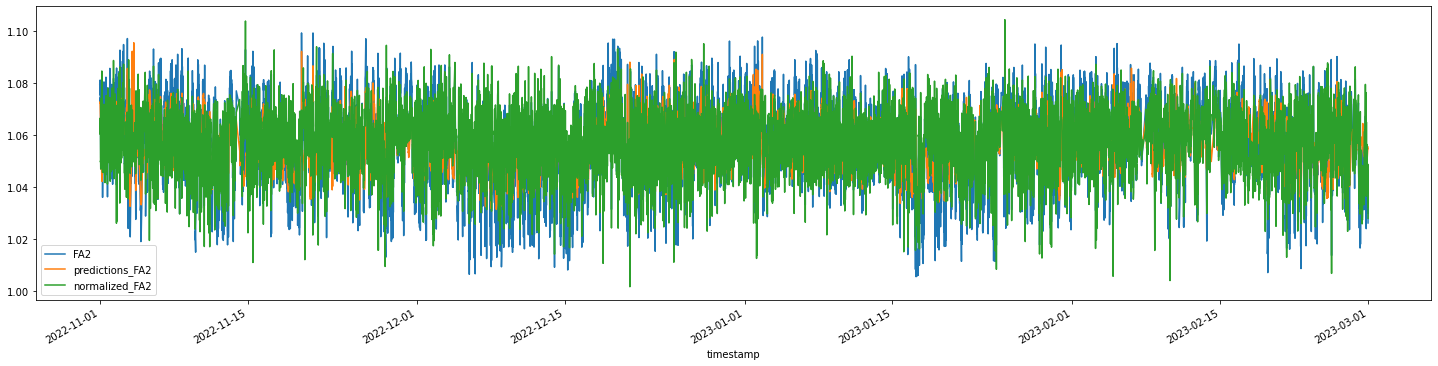

In [84]:
# Track Models in MLFlow
test_size = 0.2
random_state = 42
nb_path = os.getcwd()

site = 'NorthWester2'
site_id = 'NW2'
location_id = 'D01'
structure =  'OWT'
type = 'MPE'
model_function = 'normalization'
tags = {
        "site_id": str(site_id),
        "location_id": str(location_id),
        "structure": str(structure),
        "type": str(type)
    }

run_name = \
    '_'.join(
        [
            name_location,
            type,
            model_function,
            datetime.datetime.today().strftime('%Y-%m-%d')
        ]
    )

predictions_inv = pd.DataFrame()
models = {}

for mode in prediction_params.columns:
    with mlflow.start_run(tags=tags, run_name=run_name):
        
        mlflow.autolog(log_models=True, exclusive=False)
        y = prediction_params[mode].dropna()
        X = inputs.loc[y.index].dropna()
        y = y.loc[X.index]
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        regr = \
            Pipeline(
                steps=[
                    ('scaler', MinMaxScaler()),
                    ('regressor', LinearRegression())
                    ])
        regr.fit(X_train, y_train)

        models[mode] = regr

        metrics = mlflow.sklearn.eval_and_log_metrics(
                regr, X_test, y_test, prefix="test_"
            )
        
        params = {
                "model function": 'normalization',
                "prediction_parameter": str(mode),
                "input_parameters": str(weather_params),
                "time_period": str(start) + ' - ' + str(stop),
                "data_random_state": random_state,
                "test_size": test_size,
                "notebook": nb_path,
                "model": str(regr)
            }
        
        mlflow.log_params(params)
        predictions_mode = pd.DataFrame(
            {'predictions_'+str(mode): regr.predict(X),
            'normalized_'+str(mode): y - regr.predict(X) + np.mean(y)}, index = y.index)
        
        predictions_inv = pd.concat([predictions_inv, predictions_mode], axis = 1)
        pd.concat([y,predictions_mode], axis=1).plot(figsize=(25,6))

        model_name = '_'.join([type, site_id, location_id, str(mode)])
        mlflow.autolog(disable=True)
        mlflow.end_run()


<AxesSubplot:>

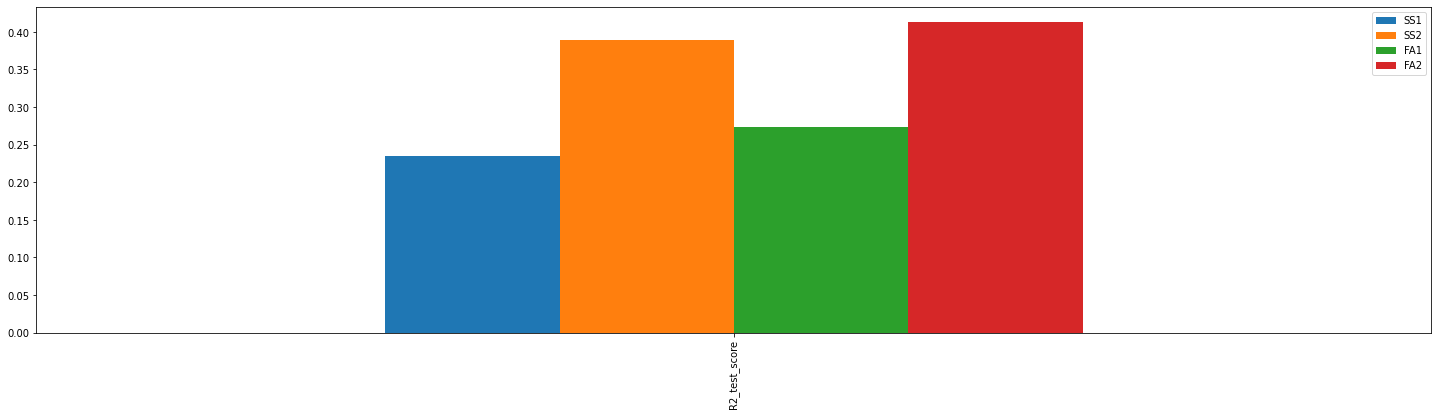

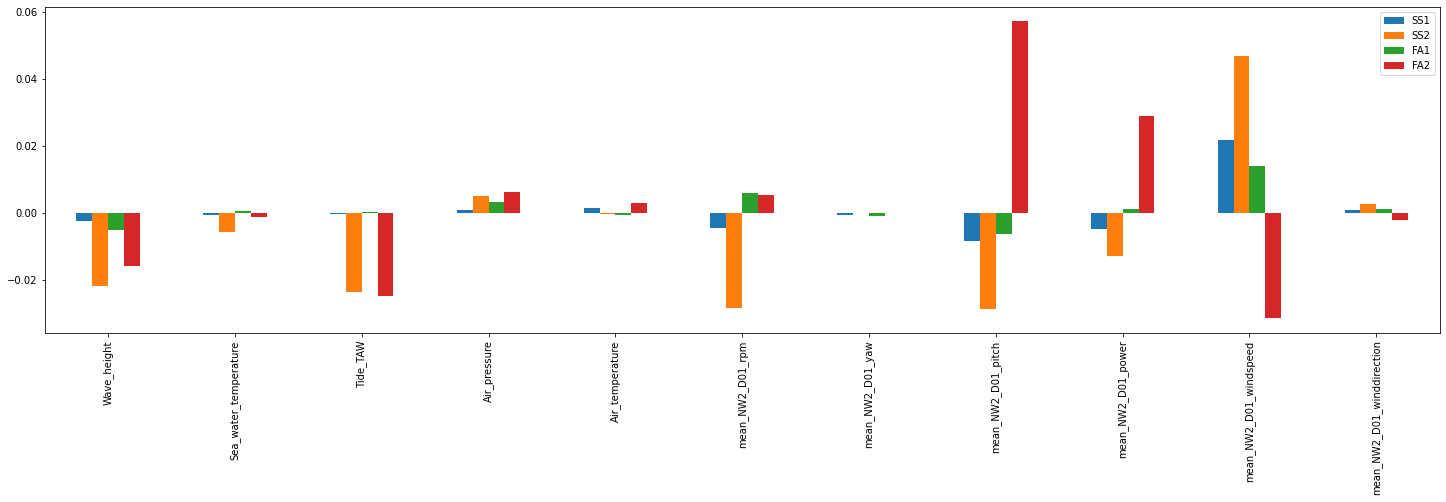

In [85]:
coef_data = {}
for mode in models.keys():
    coef_data[mode] = models[mode].steps[1][1].coef_

lin_regr_coefs = pd.DataFrame(
    coef_data,
    index = inputs.columns)

r2_test_scores = \
    pd.DataFrame(
        {
            'SS1': 0.235,
            'SS2': 0.389,
            'FA1': 0.274,
            'FA2':  0.413 
        },
        index = ['R2_test_score']
    )
r2_test_scores.plot(kind='bar', figsize=(25,6))
lin_regr_coefs.plot(kind='bar', figsize=(25,6))

2023/03/06 18:17:49 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/03/06 18:17:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/03/06 18:17:49 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/03/06 18:17:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/03/06 18:19:40 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/03/06 18:19:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2

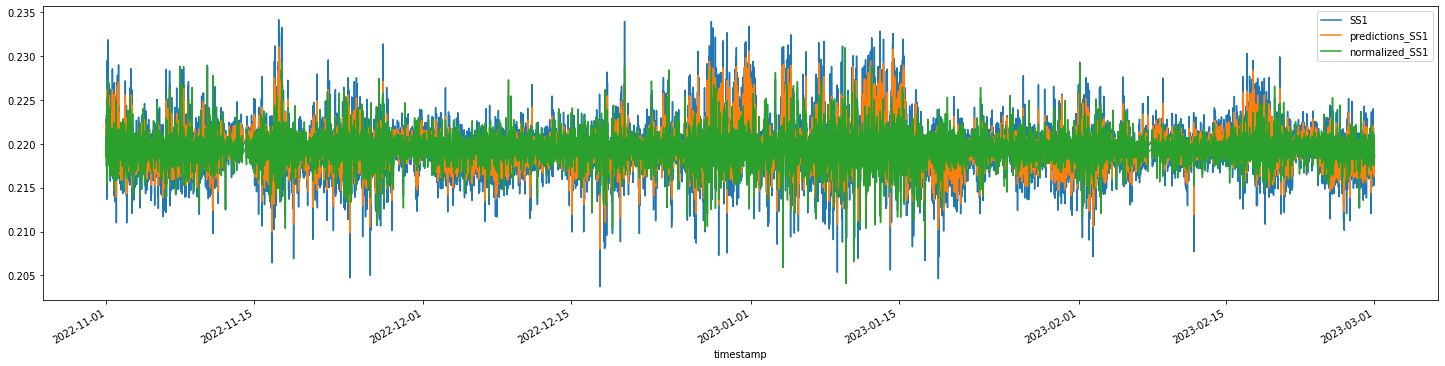

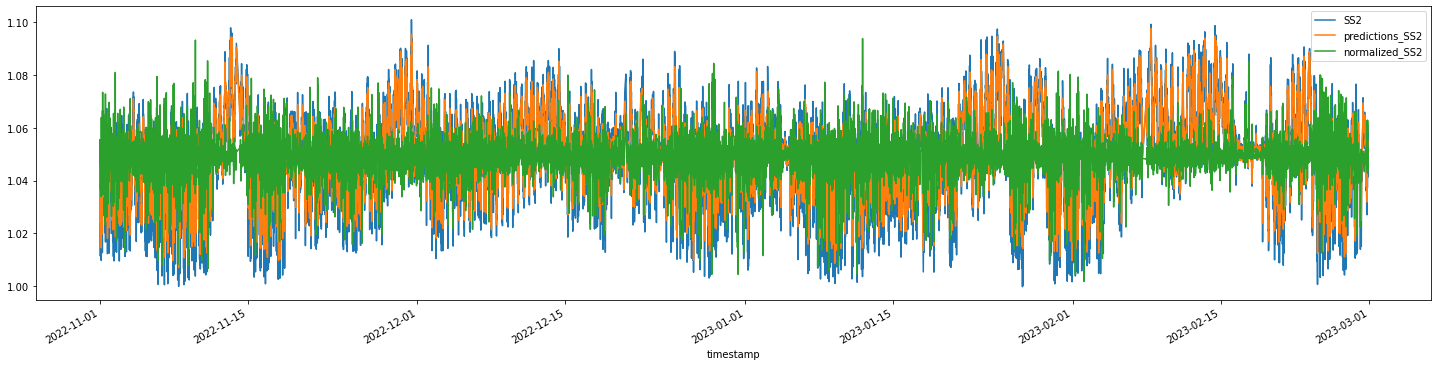

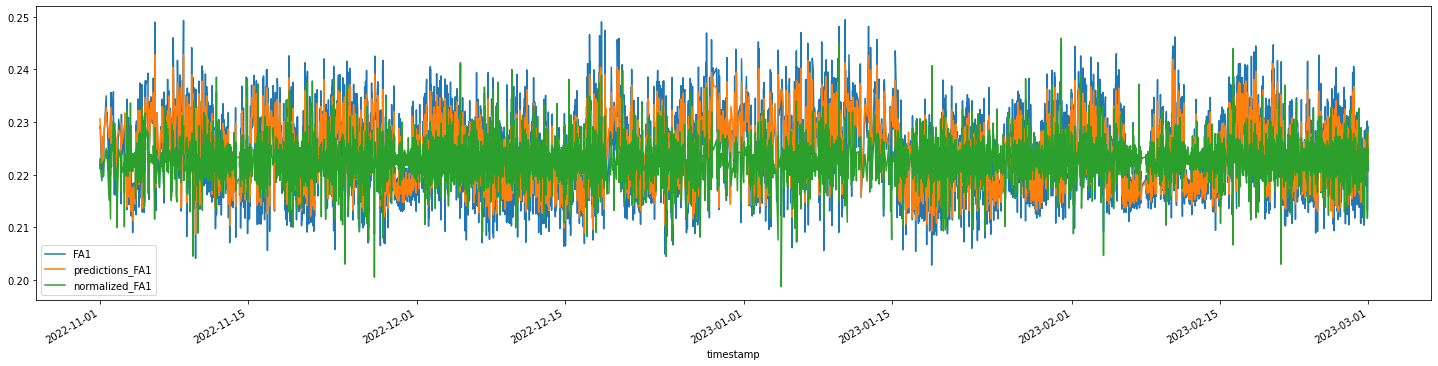

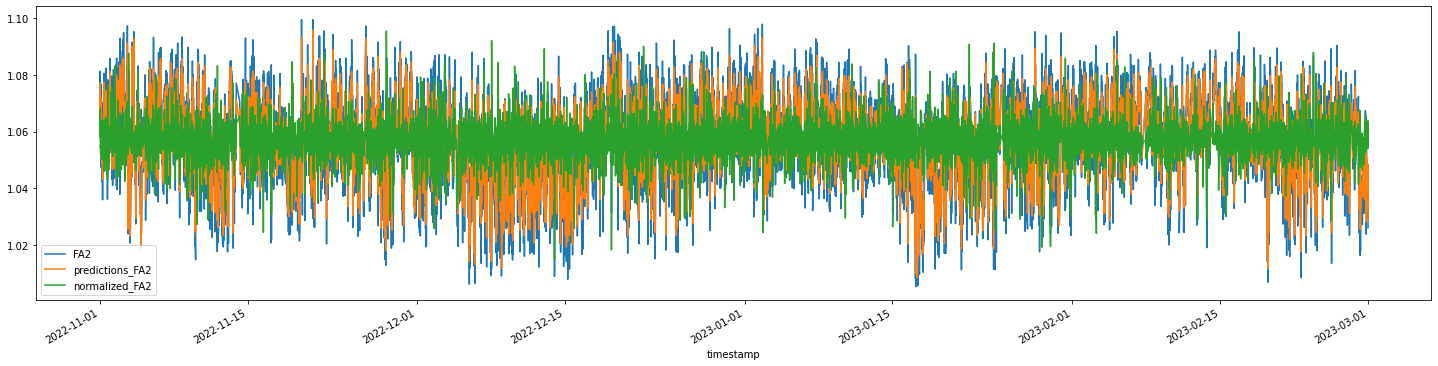

In [86]:
from mlflow.models.signature import infer_signature
from sklearn.ensemble import RandomForestRegressor

# Track Models in MLFlow
test_size = 0.2
random_state = 42
nb_path = os.getcwd()

site = 'NorthWester2'
site_id = 'NW2'
location_id = 'D01'
structure =  'OWT'
type = 'MPE'
model_function = 'normalization'
tags = {
        "site_id": str(site_id),
        "location_id": str(location_id),
        "structure": str(structure),
        "type": str(type)
    }

run_name = \
    '_'.join(
        [
            name_location,
            type,
            model_function,
            datetime.datetime.today().strftime('%Y-%m-%d')
        ]
    )

predictions_inv = pd.DataFrame()
models = {}

for mode in prediction_params.columns:
    with mlflow.start_run(tags=tags, run_name=run_name):
        
        
        mlflow.autolog(log_models=True, exclusive=False)
        y = prediction_params[mode].dropna()
        X = inputs.loc[y.index].dropna()
        y = y.loc[X.index]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        regr = RandomForestRegressor()
        regr.fit(X_train, y_train)

        models[mode] = regr

        metrics = mlflow.sklearn.eval_and_log_metrics(
                regr, X_test, y_test, prefix="test_"
            )
        
        params = {
                "model function": 'normalization',
                "prediction_parameter": str(mode),
                "input_parameters": str(weather_params),
                "time_period": str(start) + ' - ' + str(stop),
                "data_random_state": random_state,
                "test_size": test_size,
                "notebook": nb_path,
                "model": str(regr)
            }
        
        mlflow.log_params(params)
        predictions_mode = pd.DataFrame(
            {'predictions_'+str(mode): regr.predict(X),
            'normalized_'+str(mode): y - regr.predict(X) + np.mean(y)}, index = y.index)
        
        predictions_inv = pd.concat([predictions_inv, predictions_mode], axis = 1)
        pd.concat([y,predictions_mode], axis=1).plot(figsize=(25,6))

        signature = infer_signature(X_test, regr.predict(X_test))
        mlflow.autolog(disable=True)
        mlflow.end_run()

2023/03/06 18:23:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/03/06 18:23:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/03/06 18:23:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/03/06 18:23:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/03/06 18:24:14 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/03/06 18:24:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2

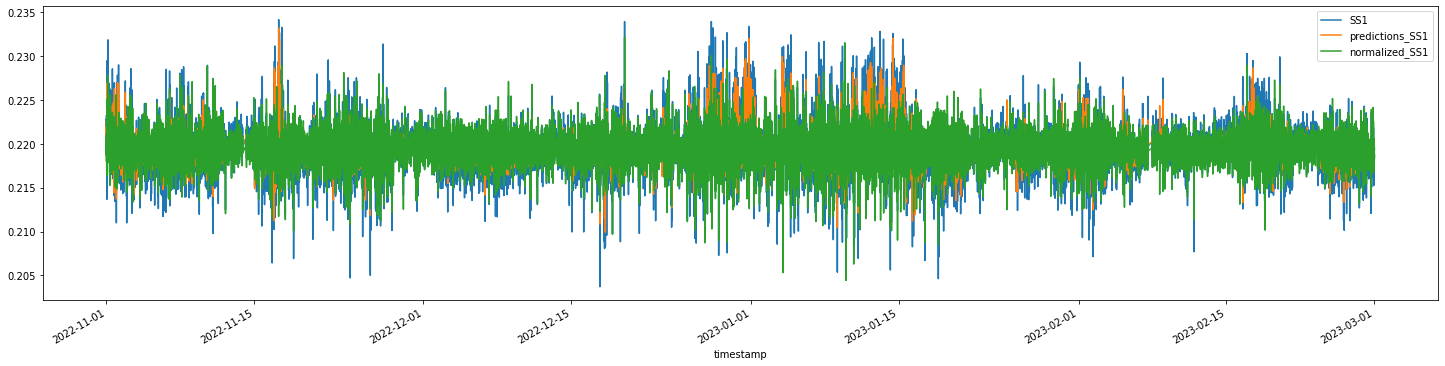

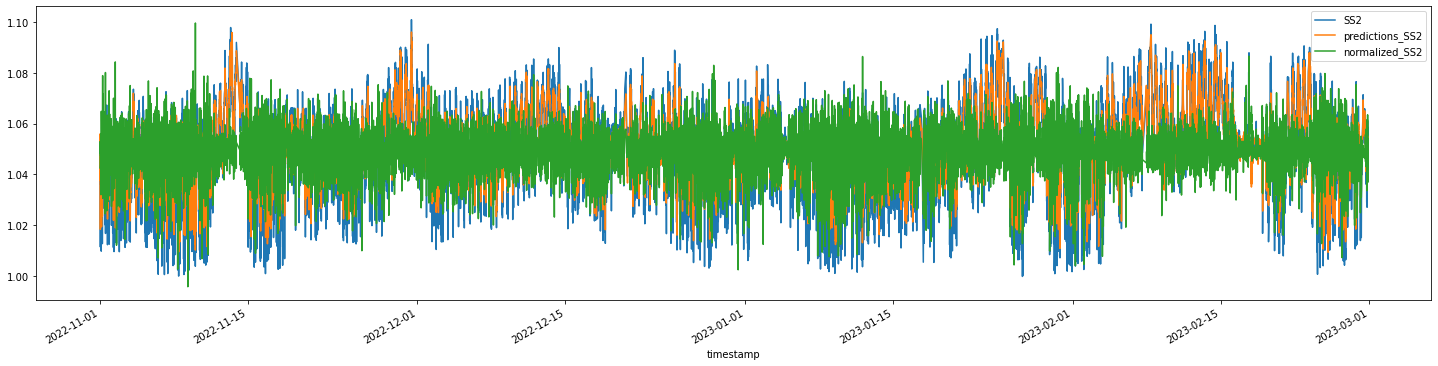

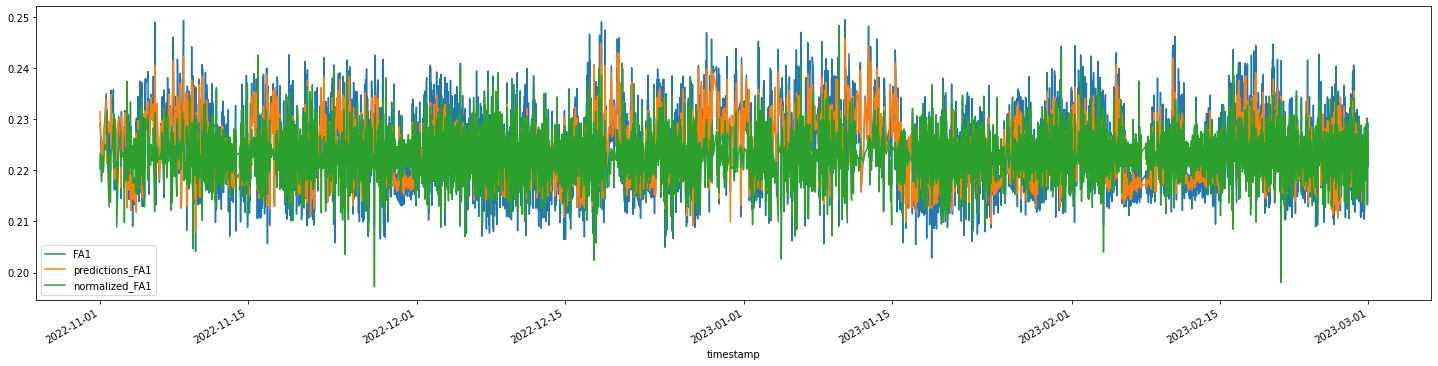

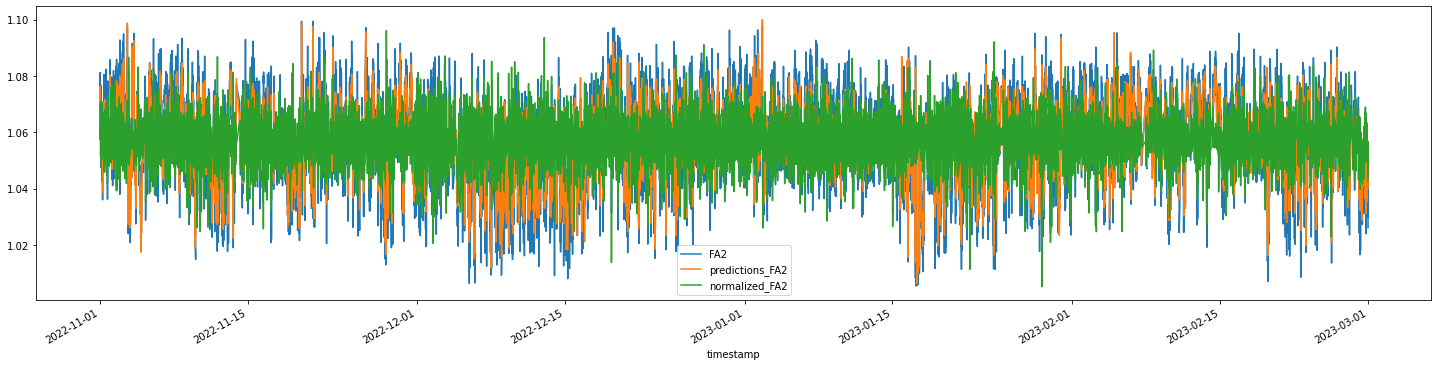

In [87]:
from xgboost import XGBRegressor

# Track Models in MLFlow
test_size = 0.2
random_state = 42
nb_path = os.getcwd()

site = 'NorthWester2'
site_id = 'NW2'
location_id = 'D01'
structure =  'OWT'
type = 'MPE'
model_function = 'normalization'
tags = {
        "site_id": str(site_id),
        "location_id": str(location_id),
        "structure": str(structure),
        "type": str(type)
    }

run_name = \
    '_'.join(
        [
            name_location,
            type,
            model_function,
            datetime.datetime.today().strftime('%Y-%m-%d')
        ]
    )

predictions_inv = pd.DataFrame()
models = {}

for mode in prediction_params.columns:
    with mlflow.start_run(tags=tags, run_name=run_name):
        
        mlflow.autolog(log_models=True, exclusive=False)
        y = prediction_params[mode].dropna()
        X = inputs.loc[y.index].dropna()
        y = y.loc[X.index]
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        regr = XGBRegressor()
        regr.fit(X_train, y_train)

        models[mode] = regr

        metrics = mlflow.sklearn.eval_and_log_metrics(
                regr, X_test, y_test, prefix="test_"
            )
        
        params = {
                "model function": 'normalization',
                "prediction_parameter": str(mode),
                "input_parameters": str(weather_params),
                "time_period": str(start) + ' - ' + str(stop),
                "data_random_state": random_state,
                "test_size": test_size,
                "notebook": nb_path,
                "model": str(XGBRegressor)
            }
        
        mlflow.log_params(params)
        predictions_mode = pd.DataFrame(
            {
                'predictions_'+str(mode): regr.predict(X),
                'normalized_'+str(mode): y - regr.predict(X) + np.mean(y)
            },
            index = y.index
        )
        
        predictions_inv = pd.concat([predictions_inv, predictions_mode], axis = 1)
        pd.concat([y,predictions_mode], axis=1).plot(figsize=(25,6))

        mlflow.autolog(disable=True)
        mlflow.end_run()

# Model Optimization

sources:

https://www.kaggle.com/code/virajbagal/eda-xgb-random-forest-parameter-tuning-hyperopt/notebook

https://www.kaggle.com/code/prashant111/bayesian-optimization-using-hyperopt

In [15]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
seed = 2

def objective_xgb(space):
    model = XGBRegressor(
                                 n_estimators = space['n_estimators'],
                                 max_depth = space['max_depth'],
                                 learning_rate = space['learning_rate'],
                                 )
    score = mean_squared_error(y_val, model.fit(X_train_val, y_train_val).predict(X_val))
    #score = cross_val_score(model,  X_train, y_train, cv=5, scoring='r2').mean()
    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': score, 'status': STATUS_OK }

def optimize_xgb(trial):
    space = {
        'n_estimators':hp.uniformint('n_estimators',100,500),
        'max_depth':hp.uniformint('max_depth',5,20),
        'learning_rate':hp.uniform('learning_rate',0.01,0.1)
    }
    best = \
        fmin(
            fn = objective_xgb,
            space = space,
            algo = tpe.suggest,
            trials = trial,
            max_evals = 100,
            rstate = np.random.default_rng(seed)
            )
    return best

XGB_optimizations = {}
for mode in prediction_params.columns:
    y = prediction_params[mode].dropna()
    X = inputs.loc[y.index].dropna()
    y = y.loc[X.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)
    trial2=Trials()
    XGB_optimizations[mode]=optimize_xgb(trial2)
    print(XGB_optimizations[mode])

100%|██████████| 100/100 [04:33<00:00,  2.73s/trial, best loss: 5.595898224294444e-06]
{'learning_rate': 0.037444362777438, 'max_depth': 5.0, 'n_estimators': 197.0}
100%|██████████| 100/100 [06:36<00:00,  3.96s/trial, best loss: 0.0001256149456776639]
{'learning_rate': 0.028434093224684254, 'max_depth': 7.0, 'n_estimators': 332.0}
100%|██████████| 100/100 [03:52<00:00,  2.32s/trial, best loss: 3.0068981319160227e-05]
{'learning_rate': 0.022284495894196944, 'max_depth': 9.0, 'n_estimators': 497.0}
100%|██████████| 100/100 [06:25<00:00,  3.85s/trial, best loss: 9.252119391803682e-05]
{'learning_rate': 0.026358541480045315, 'max_depth': 5.0, 'n_estimators': 496.0}


In [91]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
seed = 2

def objective_rf(space):
    model = RandomForestRegressor(
                                 n_estimators = space['n_estimators'],
                                 max_depth = space['max_depth'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split']
                                 )
    
    score = mean_squared_error(y_val, model.fit(X_train_val, y_train_val).predict(X_val))
    #score = cross_val_score(model,  X_train, y_train, cv=5, scoring='r2').mean()
    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -score, 'status': STATUS_OK }

def optimize_rf(trial):
    space = {
        'n_estimators': hp.uniformint('n_estimators',100,500),
        'max_depth': hp.uniformint('max_depth',5,20),
        'min_samples_leaf': hp.uniformint('min_samples_leaf',1,5),
        'min_samples_split': hp.uniformint('min_samples_split',2,6)
    }
    best = \
        fmin(
            fn = objective_rf,
            space = space,
            algo = tpe.suggest,
            trials = trial,
            max_evals = 100,
            rstate = np.random.default_rng(seed)
            )
    return best

RF_optimizations = {}
for mode in prediction_params.columns:
    y = prediction_params[mode].dropna()
    X = inputs.loc[y.index].dropna()
    y = y.loc[X.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    trial=Trials()
    RF_optimizations[mode]=optimize_rf(trial)
    print(RF_optimizations[mode])

100%|██████████| 100/100 [2:39:06<00:00, 95.46s/trial, best loss: -0.2766637889174728]  
{'max_depth': 9.0, 'min_samples_leaf': 3.0, 'min_samples_split': 5.0, 'n_estimators': 236.0}
100%|██████████| 100/100 [2:58:24<00:00, 107.04s/trial, best loss: -0.5426078972446193] 
{'max_depth': 12.0, 'min_samples_leaf': 5.0, 'min_samples_split': 4.0, 'n_estimators': 431.0}
100%|██████████| 100/100 [2:18:58<00:00, 83.39s/trial, best loss: -0.37836612385390145] 
{'max_depth': 16.0, 'min_samples_leaf': 5.0, 'min_samples_split': 2.0, 'n_estimators': 229.0}
100%|██████████| 100/100 [2:28:52<00:00, 89.32s/trial, best loss: -0.527474881625529]  
{'max_depth': 10.0, 'min_samples_leaf': 2.0, 'min_samples_split': 4.0, 'n_estimators': 325.0}


Retrain models with optimized architectures

In [101]:
def convert_float_to_int(d):
    new_dict = {}
    for key, value in d.items():
        if isinstance(value, float) and value.is_integer():
            new_dict[key] = int(value)
        else:
            new_dict[key] = value
    return new_dict
def convert_dict(d):
    new_dict = {}
    for key, value in d.items():
        new_dict[key] = convert_float_to_int(d[key])
    return new_dict

In [105]:
XGB_optimizations = convert_dict(XGB_optimizations)
RF_optimizations = convert_dict(RF_optimizations)

In [106]:
XGB_optimizations

{'SS1': {'learning_rate': 0.04007240901205307,
  'max_depth': 5,
  'n_estimators': 267},
 'SS2': {'learning_rate': 0.026619927601559498,
  'max_depth': 7,
  'n_estimators': 344},
 'FA1': {'learning_rate': 0.02706932070876298,
  'max_depth': 7,
  'n_estimators': 293},
 'FA2': {'learning_rate': 0.04924605520283076,
  'max_depth': 5,
  'n_estimators': 261}}

In [107]:
RF_optimizations

{'SS1': {'max_depth': 9,
  'min_samples_leaf': 3,
  'min_samples_split': 5,
  'n_estimators': 236},
 'SS2': {'max_depth': 12,
  'min_samples_leaf': 5,
  'min_samples_split': 4,
  'n_estimators': 431},
 'FA1': {'max_depth': 16,
  'min_samples_leaf': 5,
  'min_samples_split': 2,
  'n_estimators': 229},
 'FA2': {'max_depth': 10,
  'min_samples_leaf': 2,
  'min_samples_split': 4,
  'n_estimators': 325}}

In [109]:
RandomForestRegressor(RF_optimizations['SS1'])

RandomForestRegressor(n_estimators={'max_depth': 9, 'min_samples_leaf': 3,
                                    'min_samples_split': 5,
                                    'n_estimators': 236})

2023/03/07 11:09:20 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/03/07 11:09:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/03/07 11:09:20 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/03/07 11:09:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/03/07 11:10:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/03/07 11:10:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2

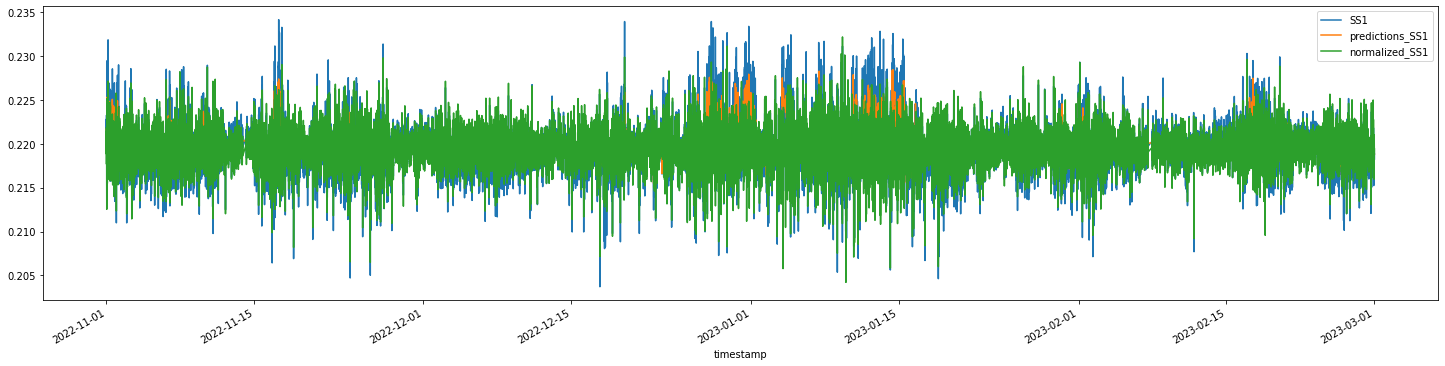

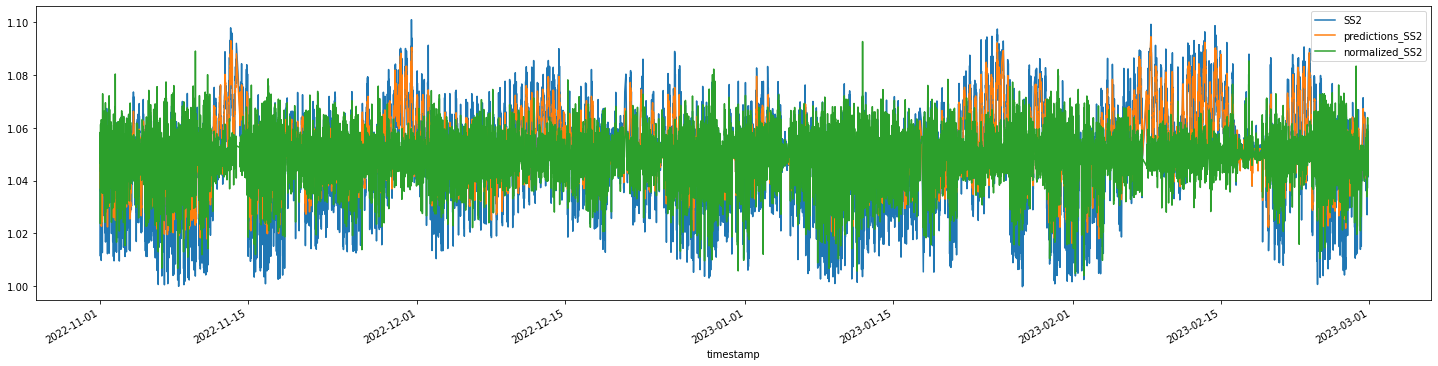

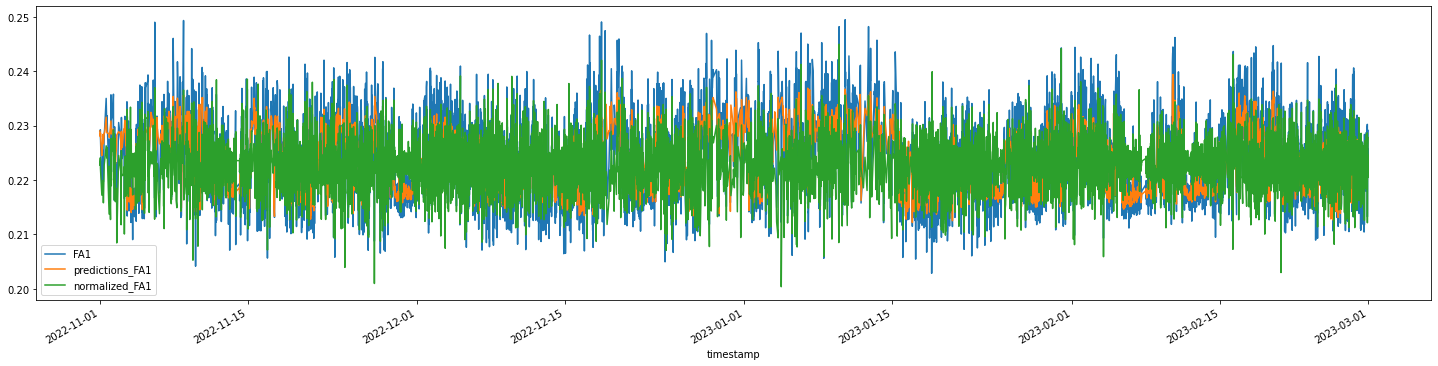

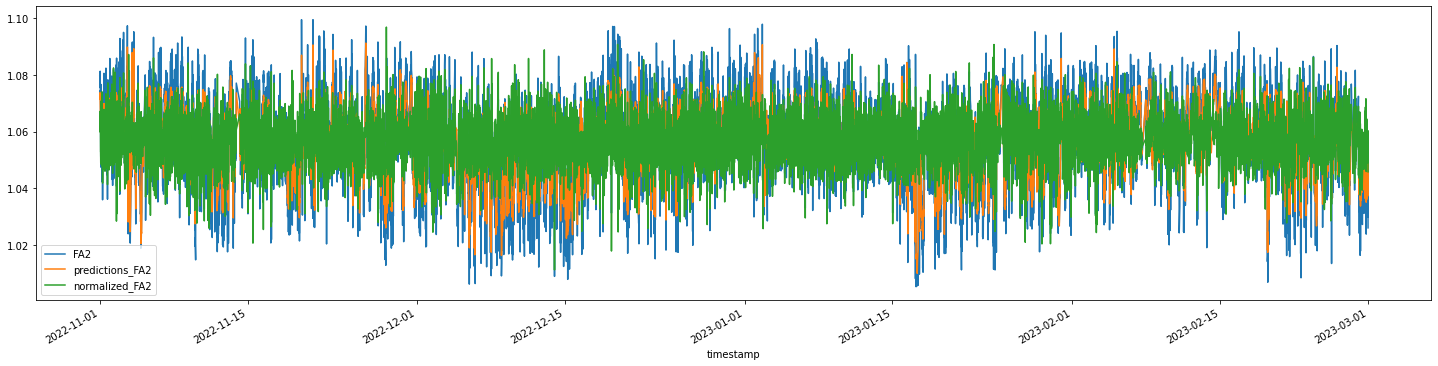

In [110]:
from mlflow.models.signature import infer_signature
from sklearn.ensemble import RandomForestRegressor

# Track Models in MLFlow
test_size = 0.2
random_state = 42
nb_path = os.getcwd()

site = 'NorthWester2'
site_id = 'NW2'
location_id = 'D01'
structure =  'OWT'
type = 'MPE'
model_function = 'normalization'
tags = {
        "site_id": str(site_id),
        "location_id": str(location_id),
        "structure": str(structure),
        "type": str(type)
    }

run_name = \
    '_'.join(
        [
            name_location,
            type,
            model_function,
            datetime.datetime.today().strftime('%Y-%m-%d')
        ]
    )

predictions_inv = pd.DataFrame()
models = {}

for mode in prediction_params.columns:
    with mlflow.start_run(tags=tags, run_name=run_name):
        
        
        mlflow.autolog(log_models=True, exclusive=False)
        y = prediction_params[mode].dropna()
        X = inputs.loc[y.index].dropna()
        y = y.loc[X.index]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        regr = \
            RandomForestRegressor(
                n_estimators = RF_optimizations[mode]['n_estimators'],
                max_depth = RF_optimizations[mode]['max_depth'],
                min_samples_leaf = RF_optimizations[mode]['min_samples_leaf'],
                min_samples_split = RF_optimizations[mode]['min_samples_split']
            )
        regr.fit(X_train, y_train)

        models[mode] = regr

        metrics = mlflow.sklearn.eval_and_log_metrics(
                regr, X_test, y_test, prefix="test_"
            )
        
        params = {
                "model function": 'normalization',
                "prediction_parameter": str(mode),
                "input_parameters": str(weather_params),
                "time_period": str(start) + ' - ' + str(stop),
                "data_random_state": random_state,
                "test_size": test_size,
                "notebook": nb_path,
                "model": str(regr)
            }
        
        mlflow.log_params(params)
        predictions_mode = pd.DataFrame(
            {'predictions_'+str(mode): regr.predict(X),
            'normalized_'+str(mode): y - regr.predict(X) + np.mean(y)}, index = y.index)
        
        predictions_inv = pd.concat([predictions_inv, predictions_mode], axis = 1)
        pd.concat([y,predictions_mode], axis=1).plot(figsize=(25,6))

        signature = infer_signature(X_test, regr.predict(X_test))
        mlflow.autolog(disable=True)
        mlflow.end_run()

2023/03/07 11:13:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/03/07 11:13:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/03/07 11:13:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/03/07 11:13:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/03/07 11:13:35 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/03/07 11:13:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2

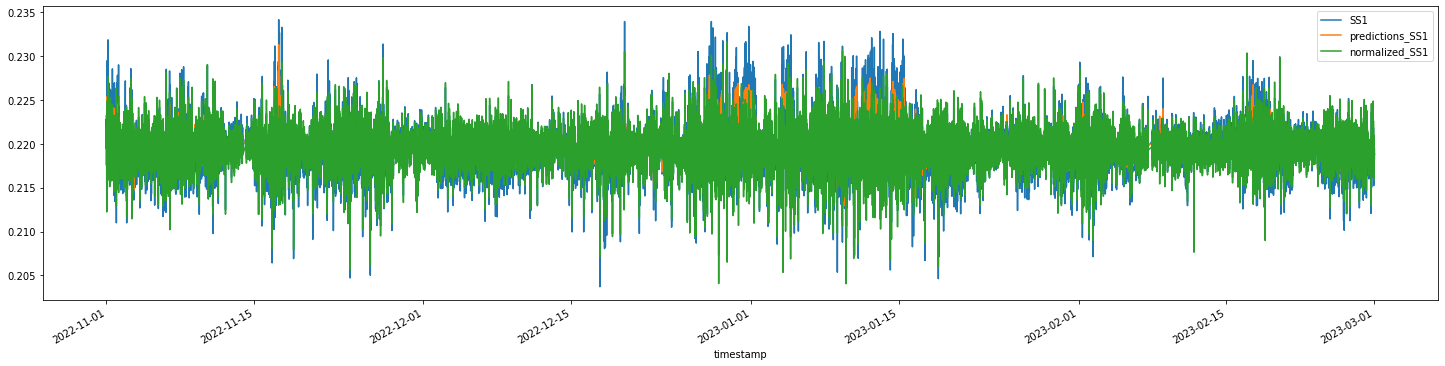

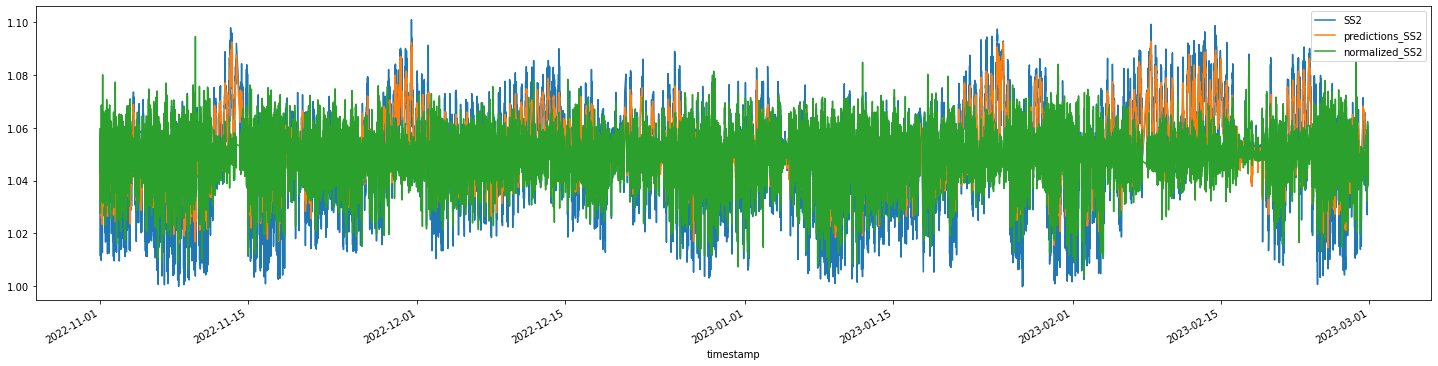

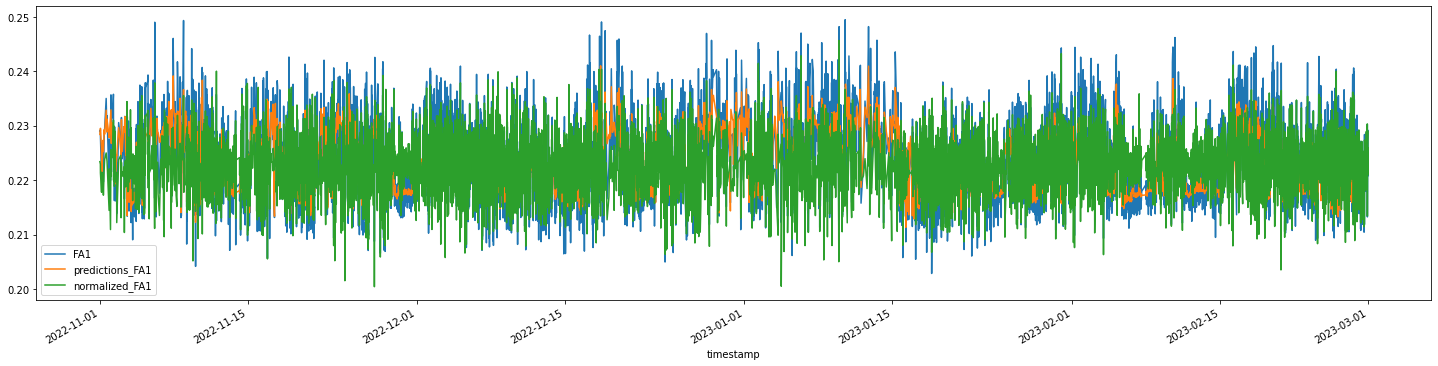

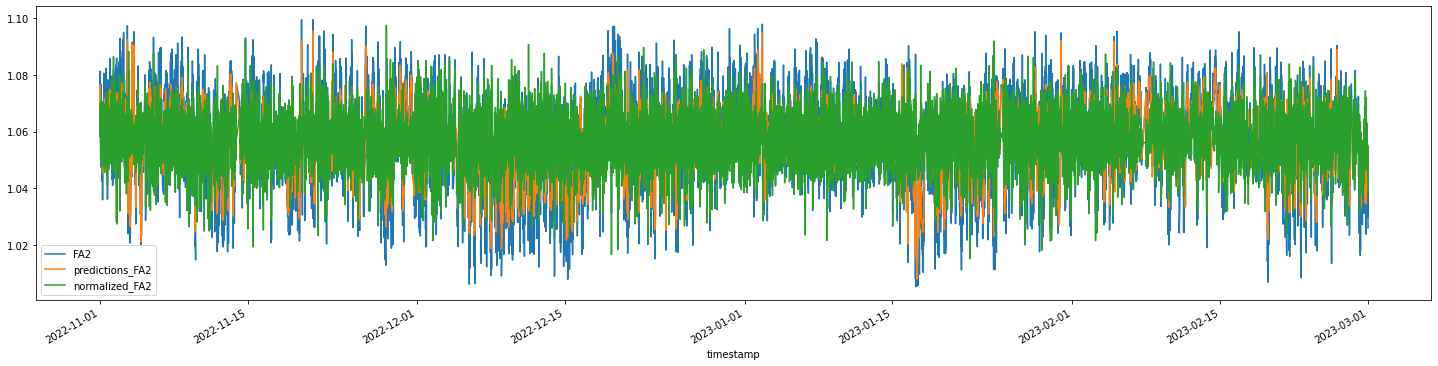

In [111]:
from xgboost import XGBRegressor

# Track Models in MLFlow
test_size = 0.2
random_state = 42
nb_path = os.getcwd()

site = 'NorthWester2'
site_id = 'NW2'
location_id = 'D01'
structure =  'OWT'
type = 'MPE'
model_function = 'normalization'
tags = {
        "site_id": str(site_id),
        "location_id": str(location_id),
        "structure": str(structure),
        "type": str(type)
    }

run_name = \
    '_'.join(
        [
            name_location,
            type,
            model_function,
            datetime.datetime.today().strftime('%Y-%m-%d')
        ]
    )

predictions_inv = pd.DataFrame()
models = {}

for mode in prediction_params.columns:
    with mlflow.start_run(tags=tags, run_name=run_name):
        
        mlflow.autolog(log_models=True, exclusive=False)
        y = prediction_params[mode].dropna()
        X = inputs.loc[y.index].dropna()
        y = y.loc[X.index]
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        regr = \
            XGBRegressor(
                n_estimators = XGB_optimizations[mode]['n_estimators'],
                max_depth = XGB_optimizations[mode]['max_depth'],
                learning_rate = XGB_optimizations[mode]['learning_rate'],
            )
        regr.fit(X_train, y_train)

        models[mode] = regr

        metrics = mlflow.sklearn.eval_and_log_metrics(
                regr, X_test, y_test, prefix="test_"
            )
        
        params = {
                "model function": 'normalization',
                "prediction_parameter": str(mode),
                "input_parameters": str(weather_params),
                "time_period": str(start) + ' - ' + str(stop),
                "data_random_state": random_state,
                "test_size": test_size,
                "notebook": nb_path,
                "model": str(XGBRegressor)
            }
        
        mlflow.log_params(params)
        predictions_mode = pd.DataFrame(
            {
                'predictions_'+str(mode): regr.predict(X),
                'normalized_'+str(mode): y - regr.predict(X) + np.mean(y)
            },
            index = y.index
        )
        
        predictions_inv = pd.concat([predictions_inv, predictions_mode], axis = 1)
        pd.concat([y,predictions_mode], axis=1).plot(figsize=(25,6))

        mlflow.autolog(disable=True)
        mlflow.end_run()